# Hands-on 07: Autoencoders for anomaly detection

The goal is to train an autoencoder to reconstruct QCD (background) jets, which are plentiful at the LHC. Then we will apply it to top quark (signal) jets to see if the reconstruction error is larger. The reconstruction error can then be used as an *anomaly* score in real data.

## Download the dataset 
We will use a validation dataset of 400k jets, which is plenty for our purposes. The full dataset is available at `https://doi.org/10.5281/zenodo.2603255`.

In [2]:
import jetnet

im_size = 16
jet_r = 0.8
max_jets = 50000

# download the validation data (400k jets, which is plenty for our purposes)
# full dataset is available here: https://doi.org/10.5281/zenodo.2603255
data = jetnet.datasets.TopTagging(
    jet_type="all",
    particle_features=["E", "px", "py", "pz"],
    jet_features=["type"],
    split="valid",
    data_dir="data/",
    particle_transform=jetnet.utils.cartesian_to_relEtaPhiPt,
    download=True,
)

/home/ilija/anaconda3/envs/deep-learn/lib/python3.10/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## Transform and split the data

The data is originally up to 200 particles per jet (zero-padded), and the features are the standard 4-vectors $(E, p_x, p_y, p_z)$. We can assume the particles are massless so $E = \sqrt{p_x^2 + p_y^2 + p_z^2}$ and there are only 3 degrees of freedom.

We will transform to relative coordinates centered on the jet using the function `jetnet.utils.cartesian_to_relEtaPhiPt`:

$$\begin{align} \eta^\mathrm{rel} &=\eta^\mathrm{particle} - \eta^\mathrm{jet}\\ \phi^\mathrm{rel} &=\phi^\mathrm{particle} - \phi^\mathrm{jet} \pmod{2\pi}\\ p_\mathrm{T}^\mathrm{rel} &= p_\mathrm{T}^\mathrm{particle} /p_\mathrm{T}^\mathrm{jet} \end{align}$$

In [3]:
import numpy as np

indices = np.random.permutation(np.arange(len(data)))[:max_jets]

# transform the data
transformed_particle_data = data.particle_transform(data.particle_data[indices])

# split qcd background and top quark signal
qcd_data = transformed_particle_data[data.jet_data[indices][:, 0] == 0]
top_data = transformed_particle_data[data.jet_data[indices][:, 0] == 1]

In [4]:
from sklearn.model_selection import train_test_split

qcd_train, qcd_test = train_test_split(qcd_data, test_size=0.2, random_state=42)
top_train, top_test = train_test_split(top_data, test_size=0.2, random_state=42)

## Convert data to jet images

In [5]:
#  convert full dataset
qcd_train_images = np.expand_dims(jetnet.utils.to_image(qcd_train, im_size=im_size, maxR=jet_r), axis=-1)
qcd_test_images = np.expand_dims(jetnet.utils.to_image(qcd_test, im_size=im_size, maxR=jet_r), axis=-1)
top_test_images = np.expand_dims(jetnet.utils.to_image(top_test, im_size=im_size, maxR=jet_r), axis=-1)

# rescale so sum is 1 (it should be close already)
qcd_train_images = qcd_train_images / np.sum(qcd_train_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)
qcd_test_images = qcd_test_images / np.sum(qcd_test_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)
top_test_images = top_test_images / np.sum(top_test_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)

## Visualize the jet images

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def plot_jet_images(images, titles, filename="jet_image.pdf"):

    n_images = len(images)
    plt.figure(figsize=(5 * n_images, 5))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n_images, i + 1)
        plt.title(title)
        plt.imshow(image, origin="lower", norm=LogNorm(vmin=1e-3, vmax=1))
        cbar = plt.colorbar()
        plt.xlabel(r"$\Delta\eta$ cell", fontsize=15)
        plt.ylabel(r"$\Delta\phi$ cell", fontsize=15)
        cbar.set_label(r"$p_T/p_T^{jet}$", fontsize=15)

    plt.tight_layout()
    plt.savefig(filename)

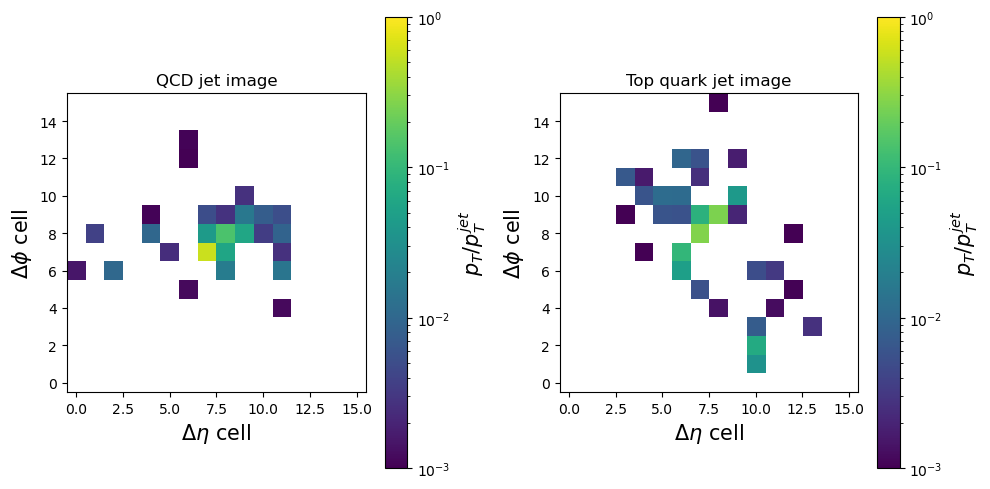

In [7]:
plot_jet_images([qcd_test_images[0], top_test_images[0]], ["QCD jet image", "Top quark jet image"])

## Define the autoencoder model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv2D,
    Conv2DTranspose,
    Reshape,
    Flatten,
    Softmax,
)

x_in = Input(shape=(im_size, im_size, 1))
x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x_in)
x = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x)
x = Flatten()(x)

x_enc = Dense(2, name="bottleneck")(x)

x = Dense(int(im_size * im_size / 16) * 128, activation="relu")(x_enc)
x = Reshape((int(im_size / 4), int(im_size / 4), 128))(x)
x = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), activation="relu", padding="same")(x)
x = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), activation="linear", padding="same")(x)
x_out = Softmax(name="softmax", axis=[-2, -3])(x)
model = Model(inputs=x_in, outputs=x_out, name="autoencoder")

model.compile(loss="mse", optimizer="adam")
model.summary()

# save the encoder-only model for easy access to latent space
encoder = Model(inputs=x_in, outputs=x_enc, name="encoder")

2025-03-07 18:01:20.854738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 18:01:20.860319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741366880.867443  710839 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741366880.869730  710839 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 18:01:20.876912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 128)      │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 1)      │         1,153 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 16, 16, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,843 (1.17 MB)

 Trainable params: 307,843 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

## Train the autoencoder model

In [9]:
history = model.fit(
    qcd_train_images,
    qcd_train_images,
    batch_size=32,
    epochs=10,
    verbose=0,
    validation_data=(qcd_test_images, qcd_test_images),
)

I0000 00:00:1741366886.104830  710981 service.cc:148] XLA service 0x7ce40000ae00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741366886.104849  710981 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-03-07 18:01:26.124378: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741366886.207604  710981 cuda_dnn.cc:529] Loaded cuDNN version 90701
E0000 00:00:1741366886.486538  710981 buffer_comparator.cc:157] Difference at 16: 0, expected 1.03784
E0000 00:00:1741366886.486561  710981 buffer_comparator.cc:157] Difference at 17: 0, expected 0.238145
E0000 00:00:1741366886.486563  710981 buffer_comparator.cc:157] Difference at 18: 0, expected 1.78276
E0000 00:00:1741366886.486564  710981 buffer_comparator.cc:157] Difference at 19: 0, expected 0.936823
E0000 00:00:

## Reconstruction performance

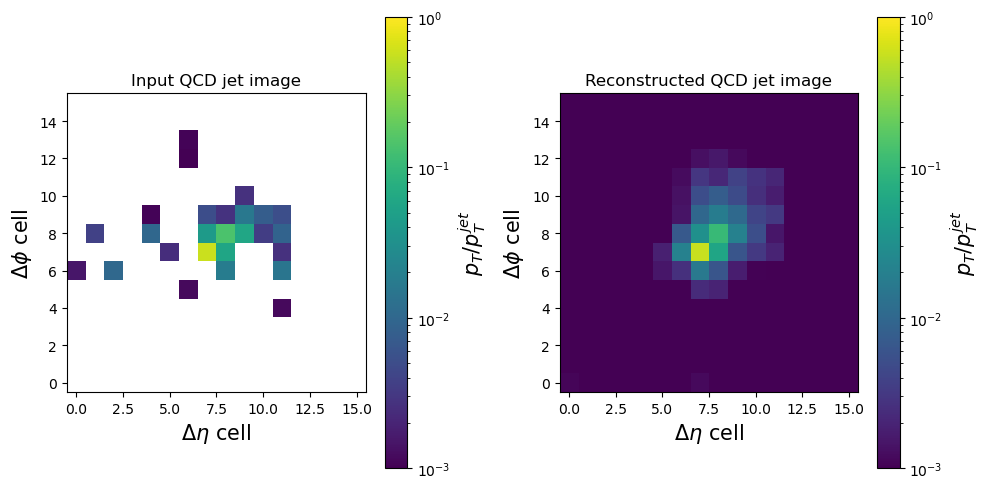

In [10]:
qcd_reco_image = model.predict(qcd_test_images[0:1], verbose=0).reshape(im_size, im_size)
plot_jet_images([qcd_test_images[0], qcd_reco_image], ["Input QCD jet image", "Reconstructed QCD jet image"])

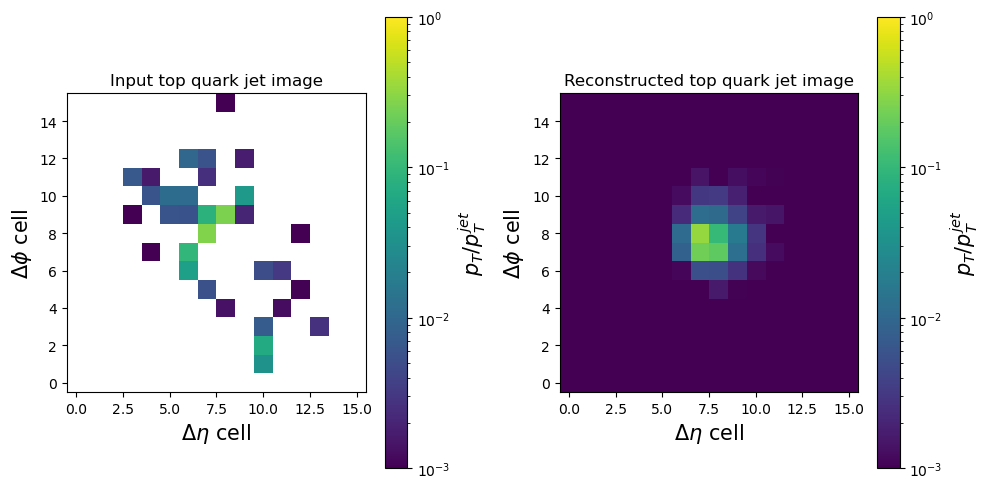

In [11]:
top_reco_image = model.predict(top_test_images[0:1], verbose=0).reshape(im_size, im_size)
plot_jet_images([top_test_images[0], top_reco_image], ["Input top quark jet image", "Reconstructed top quark jet image"])

## Anomaly detection performance

In [12]:
qcd_reco_images = model.predict(qcd_test_images, verbose=0)
top_reco_images = model.predict(top_test_images, verbose=0)

E0000 00:00:1741366927.066931  710981 buffer_comparator.cc:157] Difference at 16: -nan, expected 0.326775
E0000 00:00:1741366927.066953  710981 buffer_comparator.cc:157] Difference at 17: -nan, expected 0.178846
E0000 00:00:1741366927.066955  710981 buffer_comparator.cc:157] Difference at 18: -nan, expected 0.550162
E0000 00:00:1741366927.066956  710981 buffer_comparator.cc:157] Difference at 19: -nan, expected 0.339265
E0000 00:00:1741366927.066957  710981 buffer_comparator.cc:157] Difference at 20: -nan, expected 1.08162
E0000 00:00:1741366927.066958  710981 buffer_comparator.cc:157] Difference at 21: -nan, expected 0.725582
E0000 00:00:1741366927.066959  710981 buffer_comparator.cc:157] Difference at 22: -nan, expected 1.01233
E0000 00:00:1741366927.066960  710981 buffer_comparator.cc:157] Difference at 23: -nan, expected 1.16978
E0000 00:00:1741366927.066961  710981 buffer_comparator.cc:157] Difference at 24: -nan, expected 1.12268
E0000 00:00:1741366927.066961  710981 buffer_compa

In [13]:
diff_qcd = np.power((qcd_reco_images - qcd_test_images), 2)
loss_qcd = np.mean(diff_qcd.reshape(-1, im_size * im_size), axis=-1)

diff_top = np.power((top_reco_images - top_test_images), 2)
loss_top = np.mean(diff_top.reshape(-1, im_size * im_size), axis=-1)

loss_all = np.concatenate([loss_qcd, loss_top])

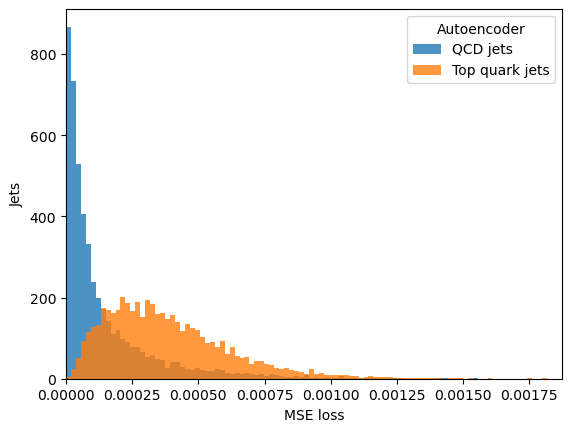

In [15]:
plt.figure()
bins = np.arange(0, np.max(loss_all), np.max(loss_all) / 100)
plt.hist(loss_qcd, label="QCD jets", bins=bins, alpha=0.8)
plt.hist(loss_top, label="Top quark jets", bins=bins, alpha=0.8)
plt.legend(title="Autoencoder")
plt.xlabel("MSE loss")
plt.ylabel("Jets")
plt.xlim(0, np.max(loss_all))
plt.show()

## Exercises

1. Plot the ROC curve for the MSE loss of the autoencoder on the merged testing sample of QCD and top quark jets, assuming a label of 1 for top quark jets and a label of 0 for QCD jets. Report the AUC.


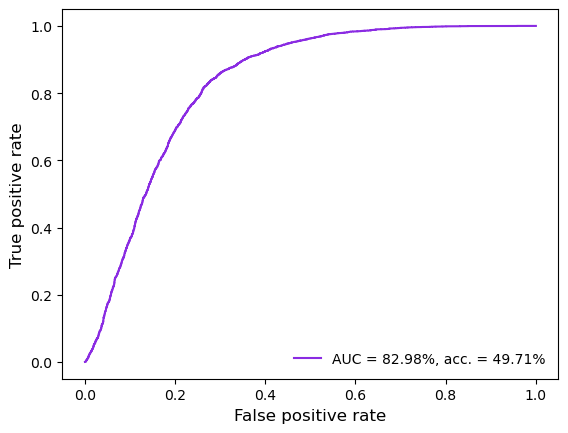

In [14]:
from roc_helper import plot_roc

y_true = np.concatenate([np.zeros_like(loss_qcd), np.ones_like(loss_top)])

fig = plot_roc(y_true, loss_all)



2. Perform a PCA on only the QCD training images using `sklearn.decomposition.PCA` with 2 components. Note you will have to reshape the image tensors so that they are 2D instead of 4D (as required by the autoencoder), e.g. `qcd_test_images.reshape(-1, im_size * im_size)`. Plot the distribution of the reconstruction losses for top quark jets and QCD jets separately. Hint: review https://rittikghosh.com/autoencoder.html.

In [67]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)

def pca_reconstruction_loss(images):
    tmp = images.reshape(-1, im_size * im_size)
    images_pca = pca.fit_transform(tmp)
    images_pca_inv = pca.inverse_transform(images_pca[:, :2])
    loss = np.mean( np.power( tmp - images_pca_inv, 2), axis= -1)
    
    return images_pca, loss

qcd_images_pca, loss_qcd_pca = pca_reconstruction_loss(qcd_test_images)
top_images_pca, loss_top_pca = pca_reconstruction_loss(top_test_images)

loss_all_pca = np.concatenate([loss_qcd_pca, loss_top_pca])

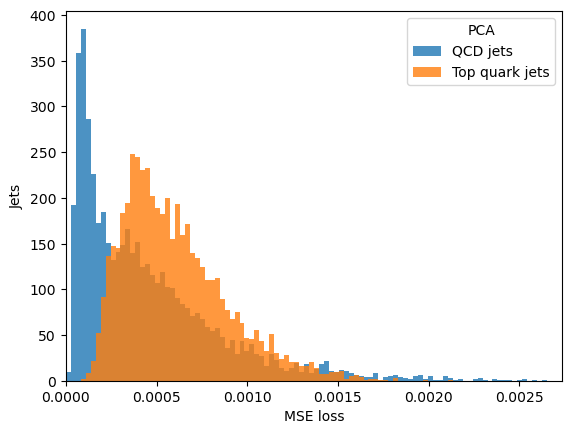

In [68]:
plt.figure()
bins = np.arange(0, np.max(loss_all_pca), np.max(loss_all_pca) / 100)
plt.hist(loss_qcd_pca, label="QCD jets", bins=bins, alpha=0.8)
plt.hist(loss_top_pca, label="Top quark jets", bins=bins, alpha=0.8)
plt.legend(title="PCA")
plt.xlabel("MSE loss")
plt.ylabel("Jets")
plt.xlim(0, np.max(loss_all_pca))
plt.show()

3. Plot the PCA ROC curve similar to part 1. Report the AUC.

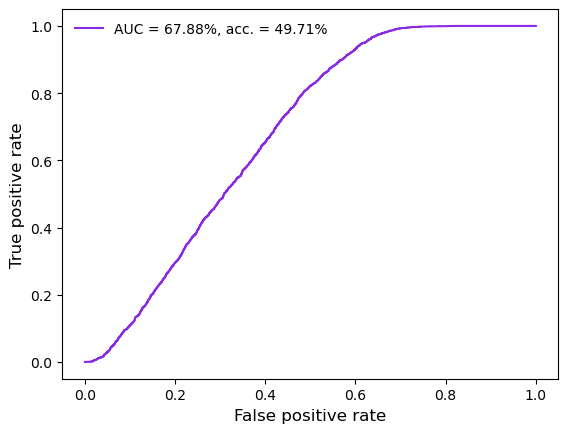

In [69]:
y_true_pca = np.concatenate([np.zeros_like(loss_qcd_pca), np.ones_like(loss_top_pca)])
fig = plot_roc(y_true_pca, loss_all_pca)



4. Plot the 2D latent space for the QCD and top quark test images for both the autoencoder and the PCA.

In [ ]:

qcd_images_encoded = encoder.predict(qcd_test_images, verbose=0)
top_images_encoded = encoder.predict(top_test_images, verbose=0)


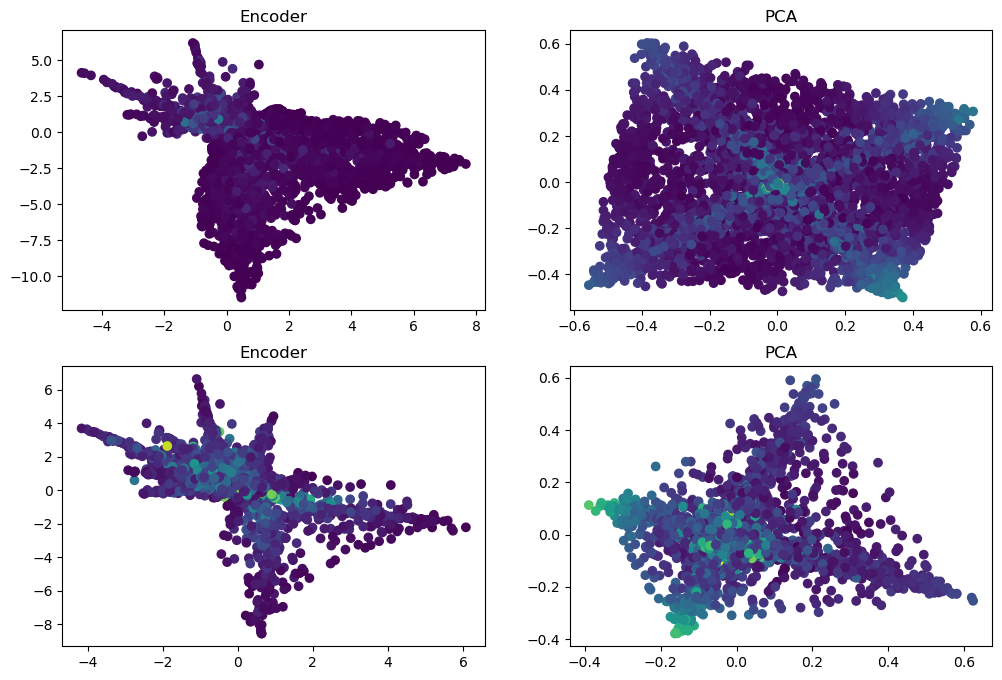

In [ ]:
fig, ax= plt.subplots(2,2, figsize=(12,8))

ax[0, 0].scatter(qcd_images_encoded[:, 0], qcd_images_encoded[:,1], c = loss_qcd)
ax[1, 0].scatter(top_images_encoded[:,0],top_images_encoded[:,1], c = loss_top)

ax[0, 1].scatter(qcd_images_pca[:, 0], qcd_images_pca[:,1], c = loss_qcd_pca)
ax[1, 1].scatter(top_images_pca[:, 0], top_images_pca[:,1], c = loss_top_pca)

for i in range(2): 
    ax[i, 0].set_title("Encoder")
    ax[i, 1].set_title("PCA")

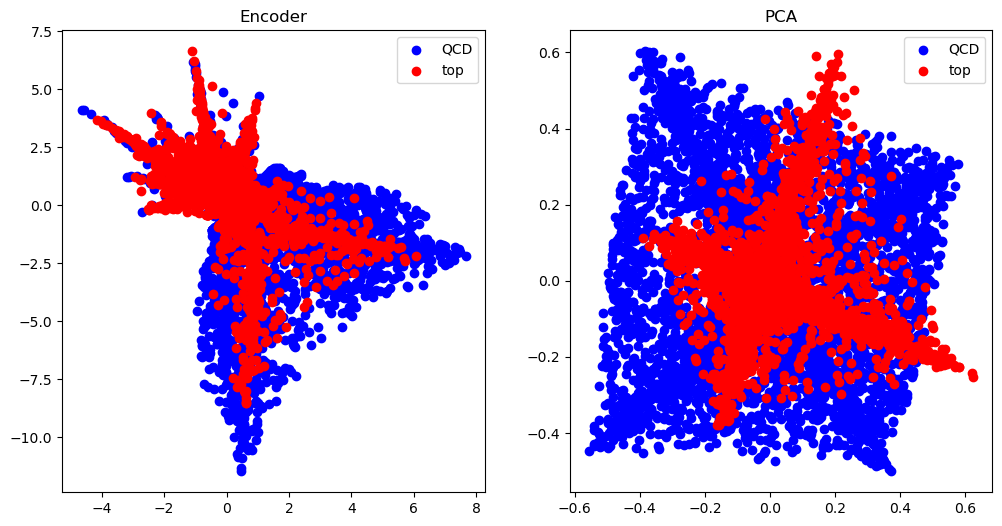

In [92]:
fig, ax= plt.subplots(1,2, figsize=(12,6))

ax[0].scatter(qcd_images_encoded[:, 0], qcd_images_encoded[:,1], c = "blue", label = "QCD")
ax[0].scatter(top_images_encoded[:,0],top_images_encoded[:,1], c = "red", label = "top")
ax[0].set_title("Encoder")
ax[0].legend()

ax[1].scatter(qcd_images_pca[:, 0], qcd_images_pca[:,1], c = "blue", label = "QCD")
ax[1].scatter(top_images_pca[:, 0], top_images_pca[:,1], c = "red", label = "top")
ax[1].set_title("PCA")
ax[1].legend()



65536